# **Multiclass classifier to detect whether an online post is harmful to children**

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/Omdena projects/Marseille_chapter

/content/drive/MyDrive/Colab Notebooks/Omdena projects/Marseille_chapter


In [4]:
df = pd.read_csv('combined_data.csv')

# Data preprocessing

In [5]:
# Drop missing values
df.dropna(inplace=True)

In [6]:
import re
def remove_urls(text):
    # Remove any string that starts with either http:// , https:// , ftp:// or www. plus
    # any combination of non white space characters.
    text = re.sub('http[s]?://\S+', '', text, flags=re.MULTILINE)
    text = re.sub('ftp?://\S+', '', text, flags=re.MULTILINE)
    text = re.sub('www.\S+', '', text, flags=re.MULTILINE)
    return text

def remove_accents(text):

    #Removes accents from a given string.

    text = re.sub('[Ã©Ã¨ÃªÃ«]', "e", text)
    text = re.sub("[Ã¹Ã»Ã¼]", "u", text)
    text = re.sub("[Ã´Ã¶]", "o", text)
    text = re.sub("Ã§", "c", text)
    text = re.sub("[Ã¯Ã®]", "i", text)
    text = re.sub("[Ã Ã¢]", "a", text)
    text = re.sub("Ã¿", "y", text)
    return text

In [7]:
# remove any digit in the text
def remove_all_numbers(text):
    return re.sub(r'\d+', ' ', text)

def remove_extra_whitespaces(text):
    return ' '.join(text.split())

def remove_mention_hashtag(text):
    text = re.sub("@[A-Za-z0-9_]+","",text)
    text = re.sub("#[A-Za-z0-9_]+","", text)
    return text


In [8]:
#functions can be added or removed
def preprocess(data):
    data = str(data)
    text = remove_urls(data)  # ok
    # text = remove_punctuations(text)
    # text = remove_accents(text)
    # text= remove_stopwords_from_tokens(text.split())
    # text = remove_emoji(text)
    text = remove_all_numbers(text)
    text = remove_extra_whitespaces(text)
    text = remove_mention_hashtag(text)
    return text

In [9]:
df['text'] = df['text'].apply(lambda x: preprocess(x))

In [10]:
df.head()

,text,label
0,"Dès les premières pages, on peut constater un ...",none
1,penser qu’il y a trop d’immigrés n’est pas du...,none
2,.antoine c'est magnifique ce que tu dis parce ...,bullying
3,en quoi?,none
4,.antoine content que tu pose la question : une...,none


In [11]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


In [12]:
df['label'].value_counts()

none           5852
homophobia     1866
hate_speech    1139
bullying        866
sexism          271
racism          262
Name: label, dtype: int64

In [13]:
# Using label encoder the labels are converted to numbers
le = preprocessing.LabelEncoder()
le.fit(df['label'])

LabelEncoder()

In [14]:
le.classes_

array(['bullying', 'hate_speech', 'homophobia', 'none', 'racism',
       'sexism'], dtype=object)

In [15]:
df['encoded_label'] = le.transform(df['label'])

In [16]:
df.head()

,text,label,encoded_label
0,"Dès les premières pages, on peut constater un ...",none,3
1,penser qu’il y a trop d’immigrés n’est pas du...,none,3
2,.antoine c'est magnifique ce que tu dis parce ...,bullying,0
3,en quoi?,none,3
4,.antoine content que tu pose la question : une...,none,3


In [17]:
X = df['text'].tolist()
y = df['encoded_label'].tolist()

In [18]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)


In [19]:
print('Train set : ', len(y_train))
print('validation set : ', len(y_val))
print('Test set : ', len(y_test))

Train set :  6922
validation set :  2308
Test set :  1026


# Loading Pretrained model Camembert

In [20]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 114.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 26.5 MB/s eta 0:00:00


In [21]:
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
from transformers import AutoTokenizer, CamembertModel, TFAutoModelForSequenceClassification
import torch

In [22]:
tokenizer = AutoTokenizer.from_pretrained("camembert-base")

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/811k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

In [58]:
# model = CamembertModel.from_pretrained("camembert-base", num_labels=6)

In [23]:

train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [24]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [25]:
train_dataset

<TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(262,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(262,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [27]:
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.)
# loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics=[tf.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='Sparse_Top_3_Categorical_Accuracy')]
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [28]:
model = TFAutoModelForSequenceClassification.from_pretrained("camembert-base", num_labels=6)

Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

Some layers of TFCamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Fine tuning the model

In [29]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [30]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer,  loss=loss, metrics=['accuracy']) #loss=model.compute_loss,

In [31]:
# model.compile(optimizer=optimizer,  loss=loss, metrics = ['accuracy']) 

In [32]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [34]:
history = model.fit(train_dataset.shuffle(1000).batch(16), epochs=10, batch_size=16,
            validation_data=val_dataset.shuffle(1000).batch(16), callbacks=[callback])

Epoch 1/10
433/433 [==============================] - 395s 913ms/step - loss: 0.9039 - accuracy: 0.7164 - val_loss: 0.6565 - val_accuracy: 0.7695
Epoch 2/10
433/433 [==============================] - 400s 924ms/step - loss: 0.5754 - accuracy: 0.8045 - val_loss: 0.5562 - val_accuracy: 0.7920
Epoch 3/10
433/433 [==============================] - 402s 929ms/step - loss: 0.4132 - accuracy: 0.8636 - val_loss: 0.5382 - val_accuracy: 0.8167
Epoch 4/10
433/433 [==============================] - 399s 923ms/step - loss: 0.3171 - accuracy: 0.8995 - val_loss: 0.4446 - val_accuracy: 0.8570
Epoch 5/10
433/433 [==============================] - 402s 929ms/step - loss: 0.2275 - accuracy: 0.9282 - val_loss: 0.4889 - val_accuracy: 0.8666
Epoch 6/10
433/433 [==============================] - 398s 919ms/step - loss: 0.1851 - accuracy: 0.9409 - val_loss: 0.6081 - val_accuracy: 0.8553
Epoch 7/10
433/433 [==============================] - 403s 931ms/step - loss: 0.1667 - accuracy: 0.9470 - val_loss: 0.4886 -

# Learning Curve

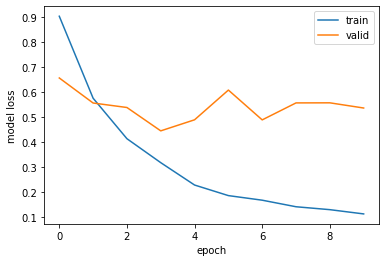

In [36]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')
plt.savefig('train_history.png')
plt.show()

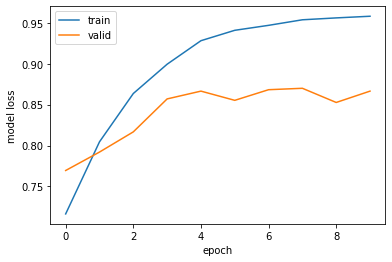

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')
plt.savefig('train_accuracy_history.png')
plt.show()

# Inference

In [63]:
# evaluate in test set
tokens=tokenizer(X_test, padding=True,truncation=True, return_tensors='tf')
logits=model.predict(dict(tokens), verbose=1).logits

33/33 [==============================] - 19s 335ms/step


In [64]:
prob=tf.nn.softmax(logits, axis=1).numpy()
predictions=np.argmax(prob, axis=1)

# Performance Metrics

In [65]:
confusion_matrix=tf.math.confusion_matrix(y_test, predictions, num_classes=6)

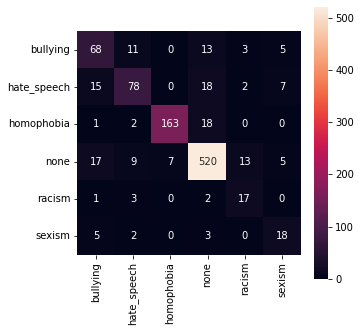

In [72]:
import seaborn as sn
plt.figure(figsize=(5,5))
sn.heatmap(confusion_matrix, annot=True, fmt='d', square=True, xticklabels=le.classes_, yticklabels=le.classes_) 

In [76]:
from sklearn import metrics
precision=metrics.precision_score(y_test, predictions, average='weighted')
recall=metrics.recall_score(y_test, predictions, average='weighted')
f1=metrics.f1_score(y_test, predictions, average='weighted')
print('Precision:{}, Recall:{}, F1 score:{}.'.format(precision, recall, f1))

Precision:0.849874704639733, Recall:0.8421052631578947, F1 score:0.844509867428115.


In [78]:
metrics.accuracy_score(y_test, predictions)

0.8421052631578947

# Save the model

In [79]:
!pwd

/content/drive/MyDrive/Colab Notebooks/Omdena projects/Marseille_chapter


In [81]:
save_directory = "/content/drive/MyDrive/Colab Notebooks/Omdena projects/Marseille_chapter/model_camembert" # change this to your preferred location

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/Colab Notebooks/Omdena projects/Marseille_chapter/model_camembert/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/Omdena projects/Marseille_chapter/model_camembert/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/Omdena projects/Marseille_chapter/model_camembert/tokenizer.json')

# Loading the saved model

In [82]:
loaded_tokenizer = AutoTokenizer.from_pretrained(save_directory)
loaded_model = TFAutoModelForSequenceClassification.from_pretrained(save_directory)

All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

All the layers of TFCamembertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/Omdena projects/Marseille_chapter/model_camembert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertForSequenceClassification for predictions without further training.


# References:
* https://huggingface.co/docs/transformers/model_doc/camembert
@inproceedings{martin2020camembert,
  title={CamemBERT: a Tasty French Language Model},
  author={Martin, Louis and Muller, Benjamin and Ortiz Su{\'a}rez, Pedro Javier and Dupont, Yoann and Romary, Laurent and de la Clergerie, {\'E}ric Villemonte and Seddah, Djam{\'e} and Sagot, Beno{\^\i}t},
  booktitle={Proceedings of the 58th Annual Meeting of the Association for Computational Linguistics},
  year={2020}
}

* https://www.kaggle.com/code/ludovicocuoghi/twitter-sentiment-analysis-with-bert-roberta
* https://www.sunnyville.ai/fine-tuning-distilbert-multi-class-text-classification-using-transformers-and-tensorflow/
* https://colab.research.google.com/drive/1DxJZwZZvt1BiDZMRV2Ce_LXRfBE_sDVK?usp=sharing#scrollTo=BNg7Gq_qUbX0

## Notes
Can try class balancing by **RandomOverSampler**